# 1D CNN Segmentation (for PPG2ABP as example) End-to-End Pipelines

# Test GPU (Optional)
Before Starting, kindly check the available GPU from the Google Server, GPU model and other related information. It might help!

In [ ]:
import torch
print("Is CUDA enabled GPU Available?", torch.cuda.is_available())
print("GPU Number:", torch.cuda.device_count())
print("Current GPU Index:", torch.cuda.current_device())
print("GPU Type:", torch.cuda.get_device_name(device=None))
print("GPU Capability:", torch.cuda.get_device_capability(device=None))
print("Is GPU Initialized yet?", torch.cuda.is_initialized())

Is CUDA enabled GPU Available? True
GPU Number: 1
Current GPU Index: 0
GPU Type: Tesla P100-PCIE-16GB
GPU Capability: (6, 0)
Is GPU Initialized yet? True


# Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/GDrive')

Mounted at /content/GDrive


Move to the Target Directory

In [ ]:
%cd /content/GDrive/MyDrive/Colab_Notebooks/Research/PPG2ABP 

/content/GDrive/MyDrive/Colab_Notebooks/Research/PPG2ABP


List the Files and Folders Located in the Current Directory

In [ ]:
!ls

 AlbuNet_1DCNN.py		      PPG2PPG.ipynb
 BCDUNet_1DCNN.py		      PPG2PPG_Test_Dataset.h5
 BCG_Dataset_TL.h5		      PPG2PPG_Train_Dataset.h5
 BCG_Patient_Wise_Data		      PPG_ECG_to_ABP_Estimation_Pipeline.ipynb
'Copy of PAVE2ABP.ipynb'	      PPG_ECG_to_BP_Prediction_Pipeline.ipynb
 data_handling.py		      PPGSensorData.txt
 data_processing.py		      predict_test.py
 delete_short_extra_est.py	      Prepare_Label.py
 Dense_Inception_UNet_1DCNN.py	      Prepare_Train_Dictionary.py
 evaluate.py			      __pycache__
 Evaluation_Metrics_ABP.py	      Ranked_Features.h5
 Evaluation_Metrics_BP.py	      ReadingSakib5.txt
 Feature_Selection_Regression.ipynb   README.md
 helper_functions.py		      ResNet_1DCNN.py
 IBAUNet_1DCNN.py		      Res_Unet_1DCNN.py
 imports_est.py			      SEDUNet_1DCNN.py
 metrics.py			      Synthetic_PPG.h5
 ml_models.py			      TernausNet_1DCNN.py
 models_est.py			      Test_Dataset_ORG.h5
 models.py			      Train_Dataset_ORG.h5
 NABUNet_1DCNN.py		      Trained_Models
 orga

## Evaluation of Predicting ABP Waveforms

Here, we present an interactive CLI to predict the ABP waveform from PPG signal from the test data. Ground truth, prediction from approximation network and refinement network are presented, and a comparison is also demonstrated


#Import Libraries

In [ ]:
import os
import h5py
import scipy
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sn
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from pathlib import Path
from tqdm import tqdm

In [ ]:
from ml_models import *
from Evaluation_Metrics_BP import *
from Evaluation_Metrics_ABP import *
from UNet_1DCNN import UNet
from TernausNet_1DCNN import TernausNet
from AlbuNet_1DCNN import AlbuNet

In [ ]:
%matplotlib inline
sns.set_style('white')

# Set Number of Channels

In [ ]:
num_channel = 4

# Import and Prepare Data

Note: Data pre-processing was mainly conducted in MATLAB. Here, data was loaded from the GDrive and prepared for Deep Learning

### Import Dataset for Train and Test on UCI

In [ ]:
fl_Train = h5py.File(os.path.join('Train_Dataset.h5'), 'r')      # load the episode data
fl_Train['PPG'].shape

(147116, 1024)

In [ ]:
fl_Test = h5py.File(os.path.join('Test_Dataset.h5'), 'r')        # load the episode data
fl_Test['PPG'].shape

(53043, 1024)

### Prepare Train Data


In [ ]:
# intialize train data
length = 1024
X_Train = []
Y_Train_BP = []
Y_Train_ABP = []

if num_channel == 1:

    for i in tqdm(range(0, fl_Train['PPG'].shape[0]), desc='Preparing Train Data'):
        X_Train.append(np.array(fl_Train['PPG'][i][:length]).reshape(length, 1))
        Y_Train_BP.append(np.array(fl_Train['ABP'][i][:length]).reshape(length, 1))
        Y_Train_ABP.append(np.array(fl_Train['ABP_RNorm'][i][:length]).reshape(length, 1))


    X_Train = np.array(X_Train)
    Y_Train_BP = np.array(Y_Train_BP)
    Y_Train_ABP = np.array(Y_Train_ABP)
    Y_Train_ABP.shape

elif num_channel == 2:
    PPG = []
    ECG = []

    for i in tqdm(range(0, fl_Train['PPG'].shape[0]), desc='Preparing Train Data'):
        PPG.append(np.array(fl_Train['PPG'][i][:length]).reshape(length, 1))
        ECG.append(np.array(fl_Train['ECG'][i][:length]).reshape(length, 1))
        Y_Train_BP.append(np.array(fl_Train['ABP'][i][:length]).reshape(length, 1))
        Y_Train_ABP.append(np.array(fl_Train['ABP_RNorm'][i][:length]).reshape(length, 1))


    PPG = np.array(PPG)
    ECG = np.array(ECG)
    X_Train = np.stack((PPG, ECG), axis=2)
    Y_Train_BP = np.array(Y_Train_BP)
    Y_Train_ABP = np.array(Y_Train_ABP)
    Y_Train_ABP.shape

elif num_channel == 3:
    PPG = []
    VPG = []
    APG = []

    for i in tqdm(range(0, fl_Train['PPG'].shape[0]), desc='Preparing Train Data'):
        PPG.append(np.array(fl_Train['PPG'][i][:length]).reshape(length, 1))
        VPG.append(np.array(fl_Train['VPG'][i][:length]).reshape(length, 1))
        APG.append(np.array(fl_Train['APG'][i][:length]).reshape(length, 1))
        Y_Train_BP.append(np.array(fl_Train['ABP'][i][:length]).reshape(length, 1))
        Y_Train_ABP.append(np.array(fl_Train['ABP_RNorm'][i][:length]).reshape(length, 1))


    PPG = np.array(PPG)
    VPG = np.array(VPG)
    APG = np.array(APG)
    X_Train = np.stack((PPG, VPG, APG), axis=2)
    Y_Train_BP = np.array(Y_Train_BP)
    Y_Train_ABP = np.array(Y_Train_ABP)
    Y_Train_ABP.shape

elif num_channel == 4:
    PPG = []
    VPG = []
    APG = []
    ECG = []

    for i in tqdm(range(0, fl_Train['PPG'].shape[0]), desc='Preparing Train Data'):
        PPG.append(np.array(fl_Train['PPG'][i][:length]).reshape(length, 1))
        VPG.append(np.array(fl_Train['VPG'][i][:length]).reshape(length, 1))
        APG.append(np.array(fl_Train['APG'][i][:length]).reshape(length, 1))
        ECG.append(np.array(fl_Train['ECG'][i][:length]).reshape(length, 1))
        Y_Train_BP.append(np.array(fl_Train['ABP'][i][:length]).reshape(length, 1))
        Y_Train_ABP.append(np.array(fl_Train['ABP_RNorm'][i][:length]).reshape(length, 1))


    PPG = np.squeeze(np.array(PPG), axis=2)
    VPG = np.squeeze(np.array(VPG), axis=2)
    APG = np.squeeze(np.array(APG), axis=2)
    ECG = np.squeeze(np.array(ECG), axis=2)
    X_Train = np.stack((PPG, VPG, APG, ECG), axis=2)
    Y_Train_BP = np.array(Y_Train_BP)
    Y_Train_ABP = np.array(Y_Train_ABP)
    X_Train.shape

Preparing Train Data: 100%|██████████| 147116/147116 [04:33<00:00, 538.24it/s]


### Prepare Test Data

In [ ]:
# intialize test data
length = 1024
X_Test = []
Y_Test_BP = []
Y_Test_ABP = []

if num_channel == 1:

    for i in tqdm(range(0, fl_Test['PPG'].shape[0]), desc='Preparing Test Data'):
        X_Test.append(np.array(fl_Test['PPG'][i][:length]).reshape(length, 1))    # ppg signal
        Y_Test_BP.append(np.array(fl_Test['ABP'][i][:length]).reshape(length, 1)) # abp signal
        Y_Test_ABP.append(np.array(fl_Test['ABP_RNorm'][i][:length]).reshape(length, 1))


    X_Test = np.array(X_Test)
    Y_Test_BP = np.array(Y_Test_BP)
    Y_Test_ABP = np.array(Y_Test_ABP)
    Y_Test_ABP.shape

elif num_channel == 2:
    PPG = []
    ECG = []

    for i in tqdm(range(0, fl_Test['PPG'].shape[0]), desc='Preparing Test Data'):
        PPG.append(np.array(fl_Test['PPG'][i][:length]).reshape(length, 1))       # ppg signal
        ECG.append(np.array(fl_Test['ECG'][i][:length]).reshape(length, 1))       # ecg signal
        Y_Test_BP.append(np.array(fl_Test['ABP'][i][:length]).reshape(length, 1)) # abp signal
        Y_Test_ABP.append(np.array(fl_Test['ABP_RNorm'][i][:length]).reshape(length, 1))


    PPG = np.array(PPG)
    ECG = np.array(ECG)
    X_Test = np.stack((PPG, ECG), axis=2)
    Y_Test_BP = np.array(Y_Test_BP)
    Y_Test_ABP = np.array(Y_Test_ABP)
    Y_Test_ABP.shape

elif num_channel == 3:
    PPG = []
    VPG = []
    APG = []

    for i in tqdm(range(0, fl_Test['PPG'].shape[0]), desc='Preparing Test Data'):
        PPG.append(np.array(fl_Test['PPG'][i][:length]).reshape(length, 1))       # ppg signal
        VPG.append(np.array(fl_Test['VPG'][i][:length]).reshape(length, 1))       # vpg signal
        APG.append(np.array(fl_Test['APG'][i][:length]).reshape(length, 1))       # apg signal
        Y_Test_BP.append(np.array(fl_Test['ABP'][i][:length]).reshape(length, 1)) # abp signal
        Y_Test_ABP.append(np.array(fl_Test['ABP_RNorm'][i][:length]).reshape(length, 1))


    PPG = np.array(PPG)
    VPG = np.array(VPG)
    APG = np.array(APG)
    X_Test = np.stack((PPG, VPG, APG), axis=2)
    Y_Test_BP = np.array(Y_Test_BP)
    Y_Test_ABP = np.array(Y_Test_ABP)
    Y_Test_ABP.shape

elif num_channel == 4:
    PPG = []
    VPG = []
    APG = []
    ECG = []

    for i in tqdm(range(0, fl_Test['PPG'].shape[0]), desc='Preparing Test Data'):
        PPG.append(np.array(fl_Test['PPG'][i][:length]).reshape(length, 1))       # ppg signal
        VPG.append(np.array(fl_Test['VPG'][i][:length]).reshape(length, 1))       # vpg signal
        APG.append(np.array(fl_Test['APG'][i][:length]).reshape(length, 1))       # apg signal
        ECG.append(np.array(fl_Test['ECG'][i][:length]).reshape(length, 1))       # apg signal
        Y_Test_BP.append(np.array(fl_Test['ABP'][i][:length]).reshape(length, 1)) # abp signal
        Y_Test_ABP.append(np.array(fl_Test['ABP_RNorm'][i][:length]).reshape(length, 1))


    PPG = np.array(PPG)
    VPG = np.array(VPG)
    APG = np.array(APG)
    ECG = np.array(ECG)
    X_Test = np.stack((PPG, VPG, APG, ECG), axis=2)
    Y_Test_BP = np.array(Y_Test_BP)
    Y_Test_ABP = np.array(Y_Test_ABP)
    Y_Test_ABP.shape

Preparing Test Data: 100%|██████████| 53043/53043 [01:42<00:00, 515.09it/s]


### Extract SBP and DBP Label Data from the Training Set

In [ ]:
SBP_Train = []
DBP_Train = []

# SBP
for i in tqdm(range(0, fl_Train['SBP'].shape[0]), desc='Extracting Ground_Truth SBP from Training Set'):
    SBP_Train.append(np.array(fl_Train['SBP'][i][0]).reshape(1, 1)) 

SBP_Train = np.squeeze(np.array(SBP_Train),axis=2)

# DBP
for i in tqdm(range(0, fl_Train['DBP'].shape[0]), desc='Extracting Ground_Truth DBP from Training Set'):
    DBP_Train.append(np.array(fl_Train['DBP'][i][0]).reshape(1, 1)) 

DBP_Train = np.squeeze(np.array(DBP_Train),axis=2)
DBP_Train.shape

Extracting Ground_Truth DBP from Training Set: 100%|██████████| 147116/147116 [00:41<00:00, 3508.78it/s]


(147116, 1)

### Extract Ground Truth SBP and DBP from the Testing Set

In [ ]:
SBP_Test = []
DBP_Test = []

# SBP
for i in tqdm(range(0, fl_Test['SBP'].shape[0]), desc='Extracting Ground_Truth SBP from Testing Set'):
    SBP_Test.append(np.array(fl_Test['SBP'][i][0]).reshape(1, 1)) 

SBP_Test = np.squeeze(np.array(SBP_Test),axis=2)

# DBP
for i in tqdm(range(0, fl_Test['DBP'].shape[0]), desc='Extracting Ground_Truth DBP from Testing Set'):
    DBP_Test.append(np.array(fl_Test['DBP'][i][0]).reshape(1, 1)) 

DBP_Test = np.squeeze(np.array(DBP_Test),axis=2)
DBP_Test.shape

Extracting Ground_Truth DBP from Testing Set: 100%|██████████| 53043/53043 [00:15<00:00, 3506.97it/s]


(53043, 1)

### Prepare ABP Ground Truth for PPG2ABP

In [ ]:
ABP_GRND = []

for i in tqdm(range(0, fl_Test['ABP_GRND'].shape[0]), desc='Extracting Ground_Truth'):
    ABP_GRND.append(np.array(fl_Test['ABP_GRND'][i][:length]).reshape(length, 1)) 

ABP_GRND = np.array(ABP_GRND)
ABP_GRND.shape

Extracting Ground_Truth: 100%|██████████| 53043/53043 [00:17<00:00, 3104.74it/s]


(53043, 1024, 1)

### Train-Val Split [Test Data is Completely Independent]

In [ ]:
X_Train1, X_Val1, Y_Train1, Y_Val1, Y_Train2, Y_Val2, SBP_Train1, SBP_Val1, DBP_Train1, DBP_Val1 = train_test_split(X_Train, Y_Train_BP, Y_Train_ABP, SBP_Train, DBP_Train, test_size=0.2, random_state=42)

In [ ]:
X_Test1 = X_Test
Y_Test1 = Y_Test_BP
Y_Test2 = Y_Test_ABP

### Garbage Collector

In [ ]:
import gc #Garbage Collector
fl_Train = None
fl_Test = None
X_Test = None
X_Train = None
X_Val = None
SBP_Train = None
DBP_Train = None
gc.collect()

309

# Signal Estimation

Configurations

In [ ]:
# Configurations
signal_length = 1024  # Length of each Segment
model_name = 'UNet'  # UNet or UNetPP
model_depth = 5  # Number of Level in the CNN Model
model_width = 64  # Width of the Initial Layer, subsequent layers start from here
kernel_size = 3  # Size of the Kernels/Filter
num_channel = 1  # Number of Channels in the Model
D_S = 1  # Turn on Deep Supervision
A_E = 0  # Turn on AutoEncoder Mode for Feature Extraction
A_G = 0  # Turn on for Guided Attention
LSTM = 0  # Turn on BiConvLSTM Block
problem_type = 'Regression'
# pooling_type = 'mix'
output_nums = 1  # Number of Class for Classification Problems, always '1' for Regression Problems
# cardinality = 5  # Cardinality for PSP_Net
is_transconv = True # True: Transposed Convolution, False: UpSampling
'''Only required if the AutoEncoder Mode is turned on'''
# feature_number = 1024  # Number of Features to be Extracted
'''Only required for MultiResUNet'''
# alpha = 1  # Model Width Expansion Parameter, for MultiResUNet only

## Prepare Data for Deep Supervision

In [ ]:
def prepareTrainDict(y, model_depth, signal_length, model_name):
  def approximate(inp, w_len, signal_length):
    op = np.zeros((len(inp),signal_length//w_len))
    for i in range(0,signal_length,w_len):
      try:
        op[:,i//w_len] = np.mean(inp[:,i:i+w_len],axis=1)
      except Exception as e:
        print(e)
        print(i)
  	
    return op

  out = {}
  Y_Train_dict = {}
  out['out'] = np.array(y)
  Y_Train_dict['out'] = out['out']
  for i in range(1, (model_depth+1)):
    name = f'level{i}'
    if ((model_name == 'UNet') or (model_name == 'MultiResUNet') or (model_name == 'FPN')):
      out[name] = np.expand_dims(approximate(np.squeeze(y), 2**i, signal_length),axis = 2)
    elif ((model_name == 'UNetE') or (model_name == 'UNetP') or (model_name == 'UNetPP')):
      out[name] = np.expand_dims(approximate(np.squeeze(y), 2**0, signal_length),axis = 2)
    Y_Train_dict[f'level{i}'] = out[f'level{i}']
  
  return out, Y_Train_dict

In [ ]:
model_name = 'UNet' # UNet or UNetPP
X_Train3 = X_Train1
X_Test3 = X_Test1
X_Val3 = X_Val1
[Y_Train3, Y_Train_dict] = prepareTrainDict(Y_Train2, PPG2ABP_model_depth, signal_length, model_name)
[Y_Test3, Y_Test_dict] = prepareTrainDict(Y_Test2, PPG2ABP_model_depth, signal_length, model_name)
[Y_Val3, Y_Val_dict] = prepareTrainDict(Y_Val2, PPG2ABP_model_depth, signal_length, model_name)

In [ ]:
loss_weights = np.zeros(PPG2ABP_model_depth)

for i in range(0, PPG2ABP_model_depth):
   loss_weights[i] = 1-(i*0.1)
   
loss_weights

array([1.])

## Build Segmentation Model and Train

Build Model for 1D Segmentation

In [ ]:
# Build model for PPG2ABP Segmentation - Deep UNet Architecture
PAVE2ABP_Network = UNet(signal_length, model_depth, num_channel, model_width, kernel_size, problem_type=problem_type, output_nums=output_nums, ds=D_S, ae=A_E, alpha=alpha).UNet()
if D_S == 0:
    PAVE2ABP_Network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mae', 'accuracy'])
elif D_S == 1:
    PAVE2ABP_Network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mae', 'accuracy'], loss_weights= loss_weights)

Load Weights from Previously Trained Models

In [ ]:
if D_S == 0:
    PAVE2ABP_Network.load_weights('Trained_Models/PAVE2ABP_UCI_'+model_name+'_'+str(PPG2ABP_model_depth)+'_'+str(PPG2ABP_model_width)+'_'+str(kernel_size_PPG2ABP)+'_'+str(num_channel)+'_Norm.h5')
elif D_S == 1:
    PAVE2ABP_Network.load_weights('Trained_Models/PAVE2ABP_UCI_'+model_name+'_'+str(PPG2ABP_model_depth)+'_'+str(PPG2ABP_model_width)+'_'+str(kernel_size_PPG2ABP)+'_'+str(num_channel)+'.h5')

Compile and Train

In [ ]:
if D_S == 0:
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode='min'), tf.keras.callbacks.ModelCheckpoint('Trained_Models/PAVE2ABP_UCI_'+model_name+'_'
    +str(PPG2ABP_model_depth)+'_'+str(PPG2ABP_model_width)+'_'+str(kernel_size_PPG2ABP)+'_'+str(num_channel)+'_Norm.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='min')]
    history = PAVE2ABP_Network.fit(X_Train1, Y_Train2, epochs=200, batch_size=32, verbose=1, validation_data= (X_Val1, Y_Val2), shuffle= True, callbacks= callbacks)
    #
elif D_S == 1:
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_out_loss', patience=20, mode='min'), tf.keras.callbacks.ModelCheckpoint('Trained_Models/PAVE2ABP_UCI_'+model_name+'_'
    +str(PPG2ABP_model_depth)+'_'+str(PPG2ABP_model_width)+'_'+str(kernel_size_PPG2ABP)+'_'+str(num_channel)+'.h5', verbose=1, monitor='val_out_loss', save_best_only=True, mode='min')]
    history = PAVE2ABP_Network.fit(X_Train3, Y_Train_dict, epochs=200, batch_size=32, verbose=1, validation_data= (X_Val3, Y_Val_dict), shuffle= True, callbacks= callbacks)

Plot History Plots (e.g., Loss, Accuracy, etc.)

In [ ]:
def history_plot(history):
  # list all dictionaries in history
  print(history.history.keys())
  # summarize history for error
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,1)
  plt.plot(history.history['out_accuracy'])
  plt.plot(history.history['val_out_accuracy'])
  plt.title('Model Error Performance')
  plt.ylabel('Error')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
  # summarize history for loss
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,2)
  plt.plot(history.history['out_loss'])
  plt.plot(history.history['val_out_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
#
history_plot(history)

Test

In [ ]:
if D_S == 0:
    ABP_App = PAVE2ABP_Network.predict(X_Test1, verbose=1)
    print(ABP_App.shape)
    #
elif D_S == 1:
    ABP_App = PAVE2ABP_Network.predict(X_Test3, verbose=1)
    print(ABP_App[0].shape)

1658/1658 [==============================] - 41s 14ms/step
(53043, 1024, 1)


Import BP Predictions

In [ ]:
num_channel = 4

In [ ]:
infile = open('Trained_Models/Preds_SBP_PAVE2BP_' + str(num_channel) + '.p','rb')
Preds_SBP_PAVE2BP = pickle.load(infile)
infile.close()
#
infile = open('Trained_Models/Preds_DBP_PAVE2BP_' + str(num_channel) + '.p','rb')
Preds_DBP_PAVE2BP = pickle.load(infile)
infile.close()

In [ ]:
SBP = Preds_SBP_PAVE2BP.ravel()
DBP = Preds_DBP_PAVE2BP.ravel()

In [ ]:
if D_S == 0:
    ABP_App_Pred = []

    for i in tqdm(range(0, ABP_App.shape[0]), desc='Denormalizing ABP'):
        ABP_App[i] = (ABP_App[i] - min(ABP_App[i]))/(max(ABP_App[i])-min(ABP_App[i])) # Range Normalize [0 1]
        ABP_App_Pred.append((ABP_App[i]*(SBP[i] - DBP[i])) + DBP[i])

    ABP_App_Pred = np.array(ABP_App_Pred)
    print(ABP_App_Pred.shape)
    #
elif D_S == 1:
    ABP_App_Pred = []

    for i in tqdm(range(0, ABP_App[0].shape[0]), desc='Denormalizing ABP'):
        ABP_App[0][i] = (ABP_App[0][i] - min(ABP_App[0][i]))/(max(ABP_App[0][i])-min(ABP_App[0][i])) # Range Normalize [0 1]
        ABP_App_Pred.append((ABP_App[0][i]*(SBP[i] - DBP[i])) + DBP[i])

    ABP_App_Pred = np.array(ABP_App_Pred)
    print(ABP_App_Pred.shape)

Denormalizing ABP: 100%|██████████| 53043/53043 [01:44<00:00, 506.76it/s]


(53043, 1024, 1)


Visualize Outcome

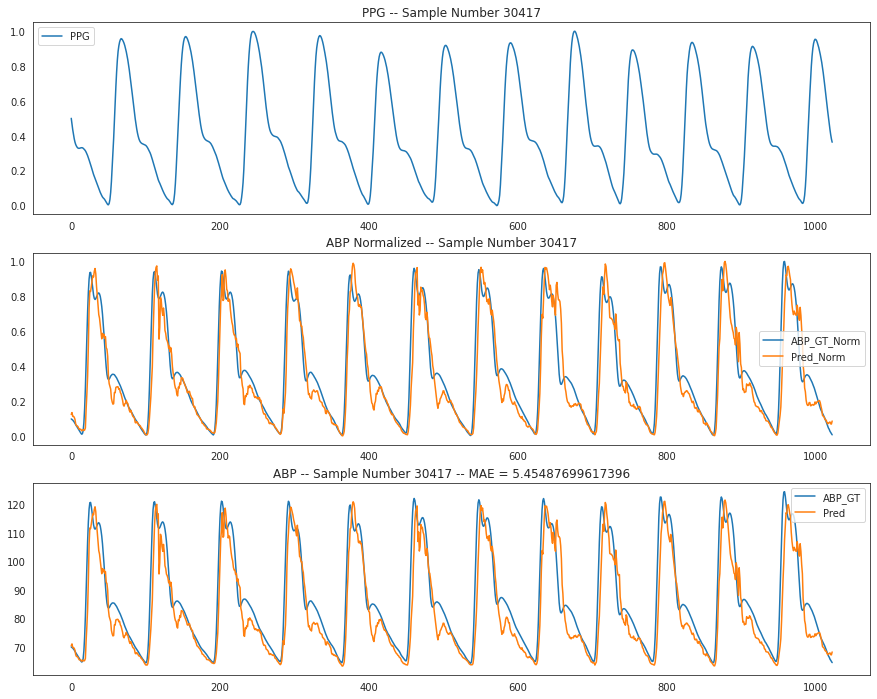

In [ ]:
if D_S == 0:
    i = random.randint(0,len(ABP_GRND))
    #
    MAE = np.mean(np.abs(ABP_App_Pred[i].ravel()-ABP_GRND[i].ravel()))
    #
    plt.figure(figsize=(15,12))
    plt.subplot(3,1,1)
    plt.plot(X_Test3[i,:,0].ravel(), label='PPG');
    plt.title(f"PPG -- Sample Number {i}")
    plt.legend();
    plt.subplot(3,1,2)
    plt.plot(Y_Test3['out'][i].ravel(), label='ABP_GT_Norm');
    plt.plot(ABP_App[i].ravel(), label='Pred_Norm');
    plt.title(f"ABP Normalized -- Sample Number {i}")
    plt.legend();
    plt.subplot(3,1,3)
    plt.plot(ABP_GRND[i],label='ABP_GT');
    plt.plot(ABP_App_Pred[i].ravel(), label='Pred');
    plt.title(f"ABP -- Sample Number {i} -- MAE = {MAE}");
    plt.legend();
    #
elif D_S == 1:
    i = np.mean(np.abs(ABP_App_Pred[i].ravel()-ABP_GRND[i].ravel()))
    #
    MAE = np.mean(np.abs(ABP_App_Pred[i].ravel()-ABP_GRND[i].ravel()))
    #
    plt.figure(figsize=(15,12))
    plt.subplot(3,1,1)
    plt.plot(X_Test3[i,:,0].ravel(), label='PPG');
    plt.title(f"PPG -- Sample Number {i}")
    plt.legend();
    plt.subplot(3,1,2)
    plt.plot(Y_Test3['out'][i].ravel(), label='ABP_GT_Norm');
    plt.plot(ABP_App[0][i].ravel(), label='Pred_Norm');
    plt.title(f"ABP Normalized -- Sample Number {i}")
    plt.legend();
    plt.subplot(3,1,3)
    plt.plot(ABP_GRND[i],label='ABP_GT');
    plt.plot(ABP_App_Pred[i].ravel(), label='Pred');
    plt.title(f"ABP -- Sample Number {i} -- MAE = {MAE}");
    plt.legend();

## Evaluate ABP Estimation Performance

Construction Error

In [ ]:
[ABP_GRND_NEW, App_Predict_NEW] = Construction_Error_ABP(ABP_GRND, ABP_App_Pred)

Construction Error : 5.717 +/- 2.673
Number of Bad Predictions = 5


BHS Metric

------------------------------------------
|        BHS-Metric-ABP Estimation        |
------------------------------------------
------------------------------------------
|       | <= 5mmHg | <=10mmHg | <=15mmHg |
------------------------------------------
|  DBP  |   99.84 %   |   99.99 %   |  100.0 %    |
|  MAP  |   90.76 %   |   99.53 %   |  99.94 %    |
|  SBP  |   92.32 %   |   99.07 %   |  99.87 %    |
------------------------------------------


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


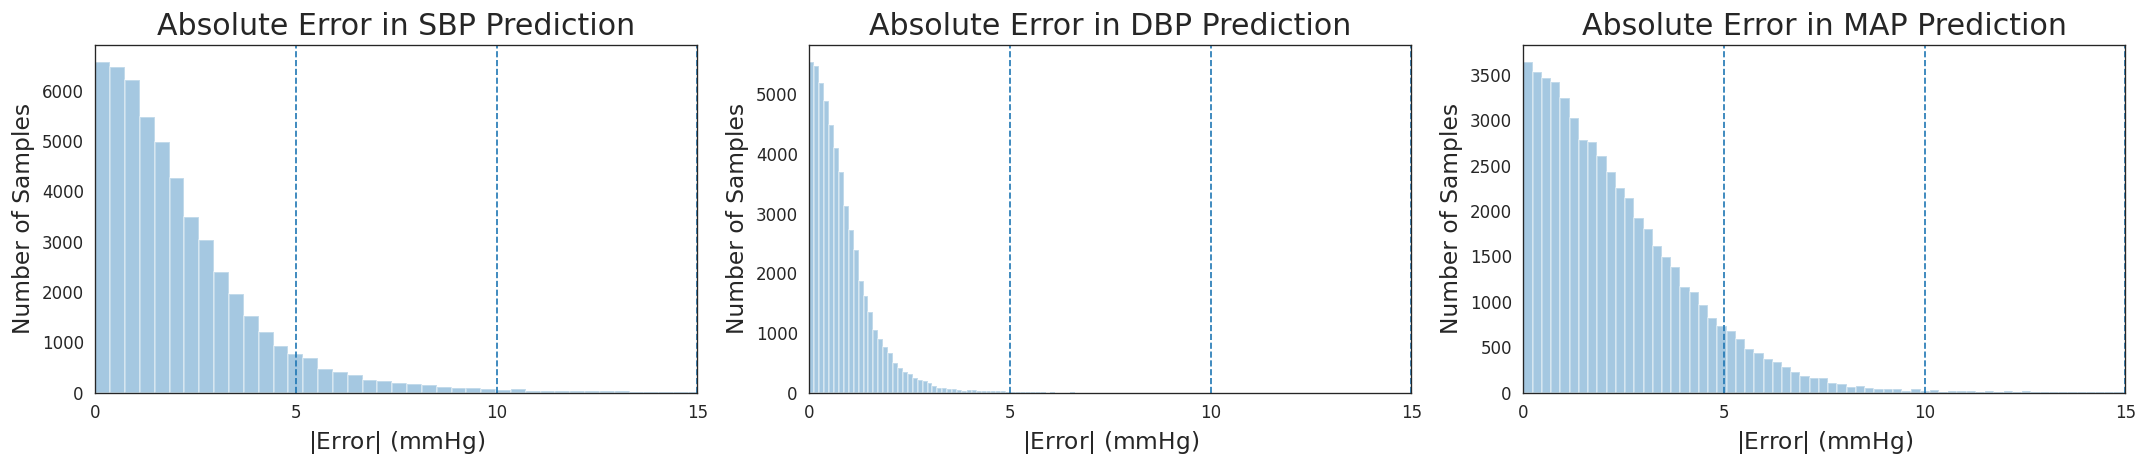

In [ ]:
BHS_Metric_ABP(ABP_GRND_NEW, App_Predict_NEW)

AAMI Standard

---------------------------------
|         AAMI Standard         |
---------------------------------
-----------------------
|     |   ME   |  STD  |
-----------------------
| DBP | -0.342 | 1.059 |
| MAP | 0.149 | 3.02 |
| SBP | -0.248 | 2.937 |
-----------------------


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


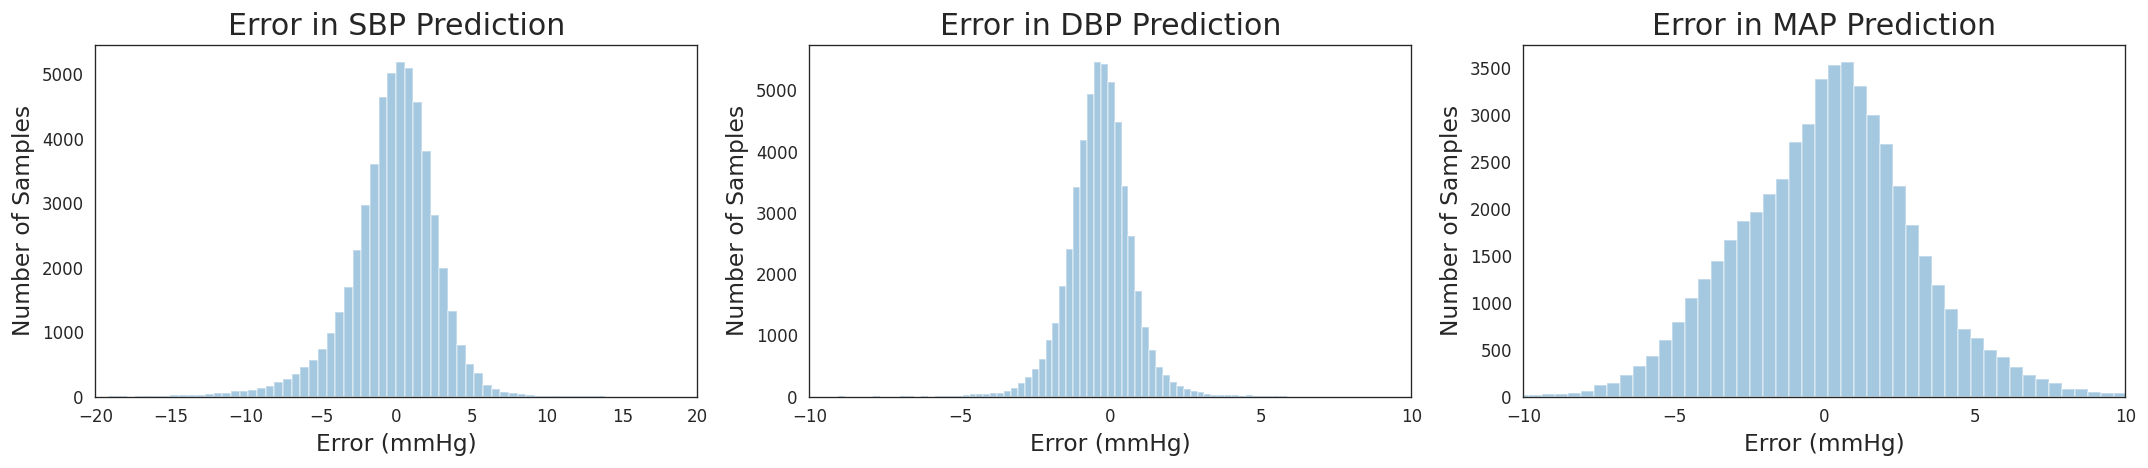

In [ ]:
calcErrorAAMI_ABP(ABP_GRND_NEW, App_Predict_NEW)

Evaluate Blood Pressure Level Classification from Estimated ABP Waveforms

DBP Classification Accuracy
                  precision    recall  f1-score   support

    Hypertension    0.96384   0.94714   0.95542      1154
    Normotension    0.99170   0.99575   0.99372     48742
Pre-hypertension    0.90955   0.85773   0.88288      3142

        accuracy                        0.98652     53038
       macro avg    0.95503   0.93354   0.94401     53038
    weighted avg    0.98623   0.98652   0.98632     53038

SBP Classification Accuracy
                 precision    recall  f1-score   support

   Hypertension    0.95048   0.95191   0.95119     19276
   Normotension    0.95438   0.93436   0.94426     15022
Prehypertension    0.89945   0.91318   0.90626     18740

       accuracy                        0.93326     53038
      macro avg    0.93477   0.93315   0.93391     53038
   weighted avg    0.93355   0.93326   0.93336     53038



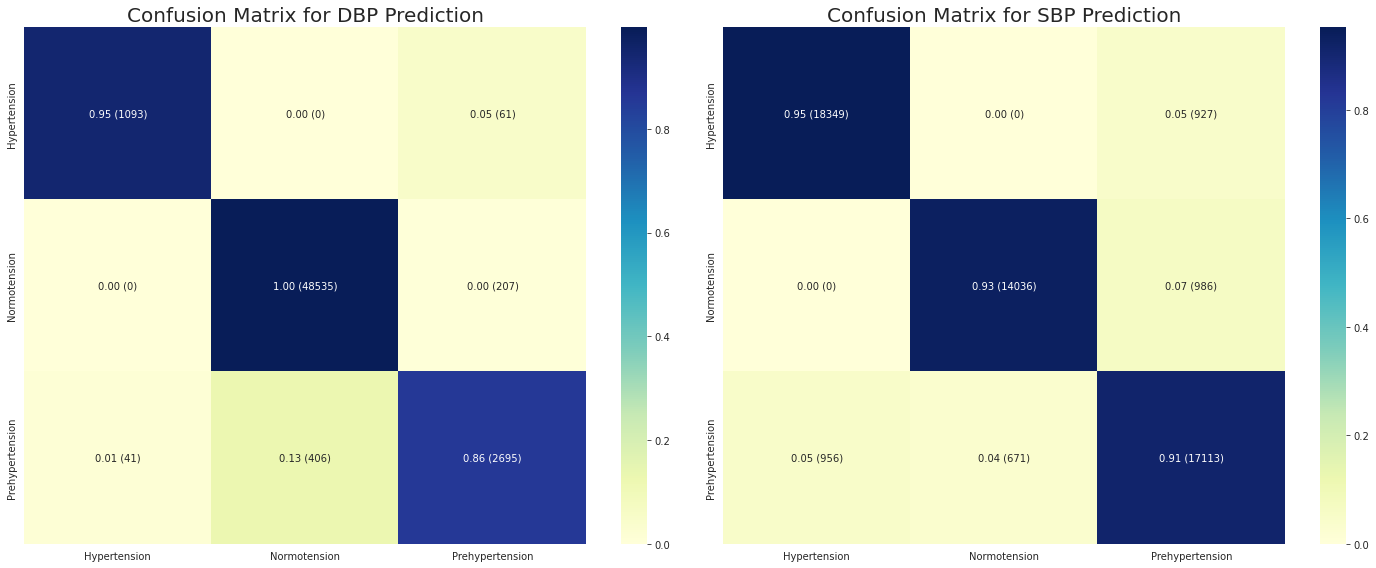

In [ ]:
evaluate_BP_Classification_ABP(ABP_GRND_NEW, App_Predict_NEW)

Regression Plots

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


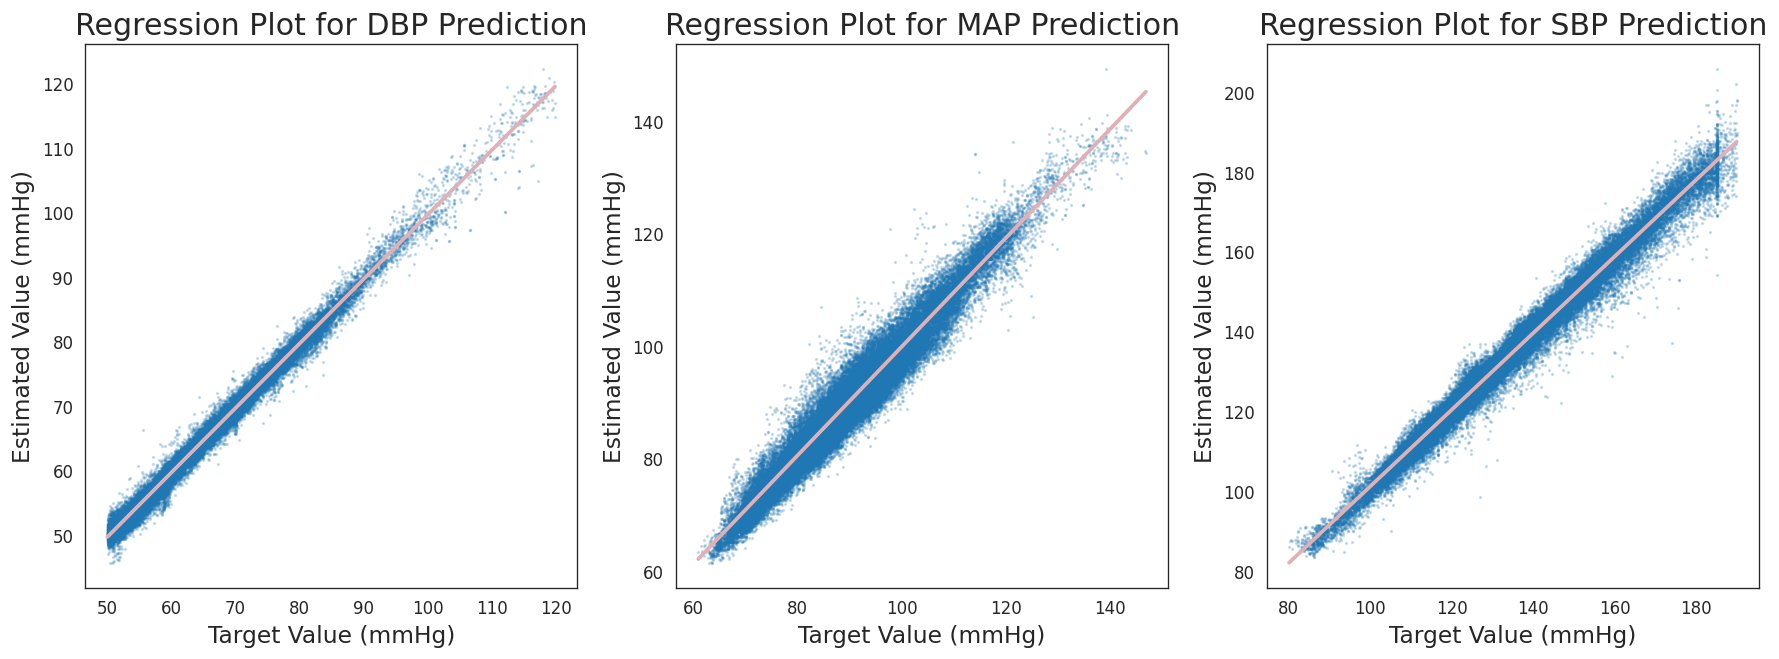

DBP
LinregressResult(slope=0.9997826732883831, intercept=-0.32807182761293063, rvalue=0.9946700507015468, pvalue=0.0, stderr=0.0004500266736446768)
MAP
LinregressResult(slope=0.9659466351020579, intercept=3.193236550526109, rvalue=0.973019600840515, pvalue=0.0, stderr=0.0009945715894430695)
SBP
LinregressResult(slope=0.9605736946518596, intercept=5.045705890969714, rvalue=0.9908125769955377, pvalue=0.0, stderr=0.0005693323240304519)


In [ ]:
regression_plot_ABP(ABP_GRND_NEW, App_Predict_NEW)

Bland-Altman Plots

---------DBP---------
2.418650611268816 -1.7342665160215638
---------MAP---------
5.770253717296468 -6.068127406251923
---------SBP---------
6.00424731326921 -5.508224141075709


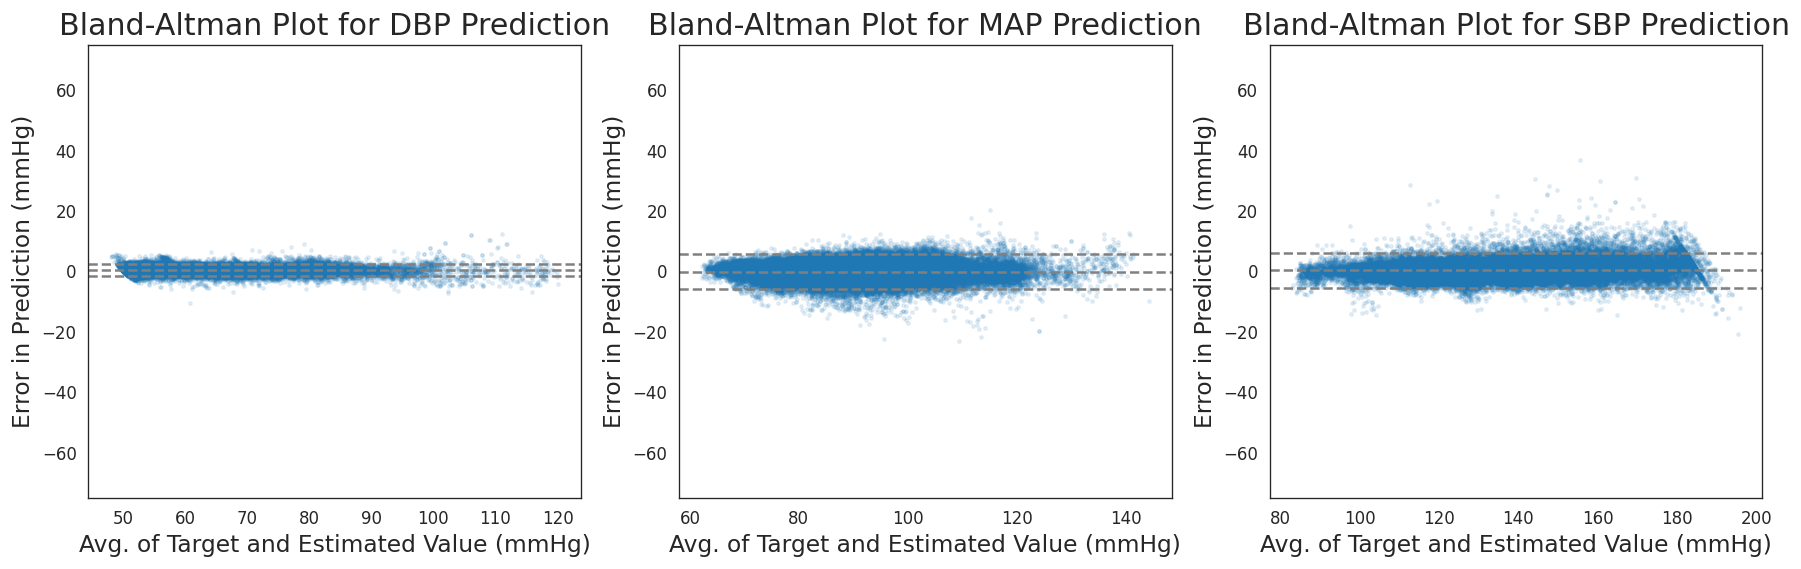

In [ ]:
bland_altman_plot_ABP(ABP_GRND_NEW, App_Predict_NEW)

# Infinite Loop to Keep the Tab Alive

In [ ]:
while True:
    pass